# # [Amet Vikram]
# # ECE 539 : Term Project
# # Dataset 3 : Emotion Detection from Text

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("tweet_emotions.csv")

In [3]:
display(df.head())

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


## Data Analysis and Exploration

<h4>Premilinary Analysis</h4>

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB
None


<p>Now from above analysis we can say few points :-</p>
<ol>
<li>The dataset only contains <strong>3 columns</strong> and there are <strong>no numerical columns</strong> in this dataset.</li>
<li>The <strong>"content"</strong> feature column will be our <strong>predictor</strong> feature column and <strong>"sentiment"</strong> will be our <strong>target feature</strong> column.</li>
<li>The <strong>"tweet_id"</strong> column is of no use in our analysis and so will be dropped during training of models.</li>
</ol>

In [4]:
target_class = "sentiment"

features_drop = pd.Index(["tweet_id"])

predictor = pd.Index(["content"])

print(predictor)
print("\n")

print("Features to drop are:-")
print(features_drop)
print("\n")

print("Target Feature:",target_class)

Index(['content'], dtype='object')


Features to drop are:-
Index(['tweet_id'], dtype='object')


Target Feature: sentiment


<h4>Null value Analysis</h4>

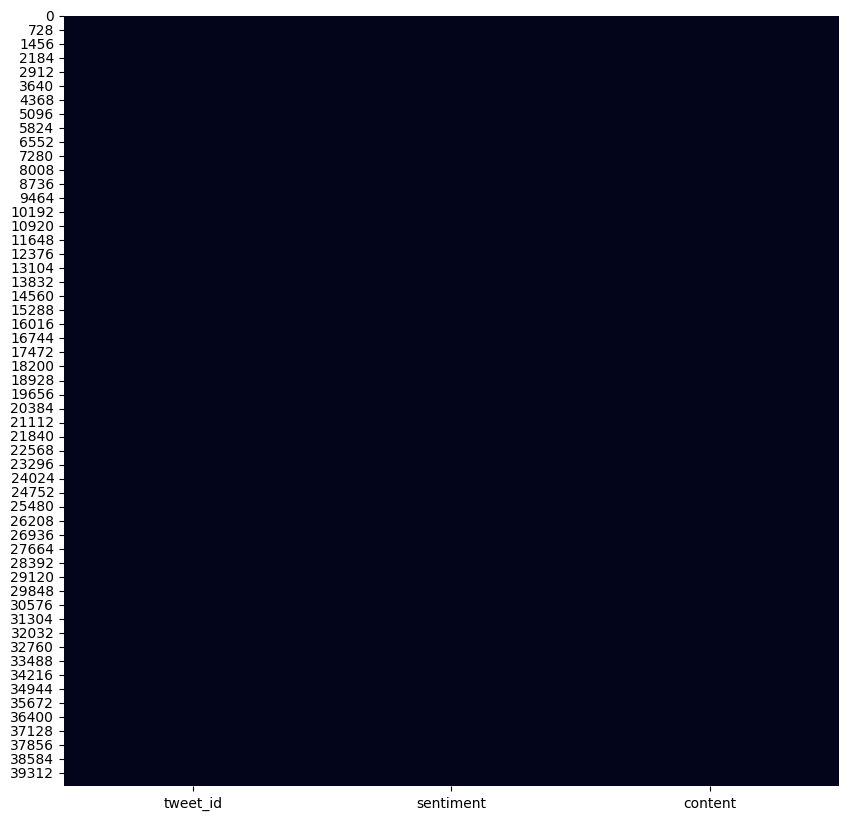

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isna(),cbar=False)
plt.show()

<p>Now from above analysis we can conclude that there are no samples with missing data. Therefor no <strong>data imputation</strong> is required for this dataset.</p>

<h4>Categorical value Analysis</h4>

In [6]:
print(target_class,":",pd.unique(df[target_class]))

sentiment : ['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [5]:
frequency_counts = df[target_class].value_counts()

frequency_percentage = (frequency_counts / len(df[target_class])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

cardinality = df[target_class].nunique()
print(f"\ntotal values: {cardinality}")

            Counts  Percentage
sentiment                     
neutral       8638     21.5950
worry         8459     21.1475
happiness     5209     13.0225
sadness       5165     12.9125
love          3842      9.6050
surprise      2187      5.4675
fun           1776      4.4400
relief        1526      3.8150
hate          1323      3.3075
empty          827      2.0675
enthusiasm     759      1.8975
boredom        179      0.4475
anger          110      0.2750

total values: 13


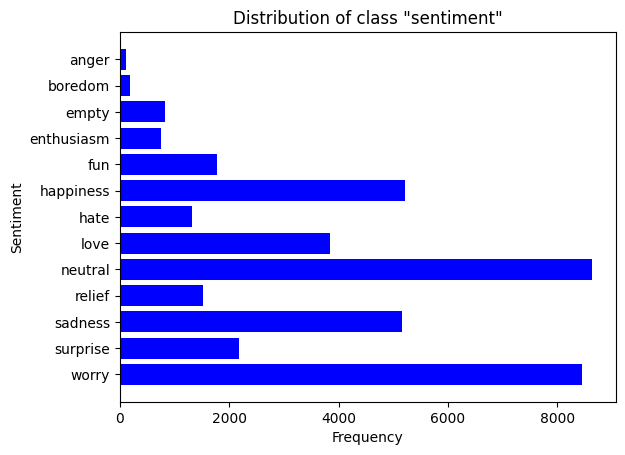

In [6]:
sentiment_counts = df[target_class].value_counts().sort_index()

sentiments = sentiment_counts.index
frequencies = sentiment_counts.values

plt.barh(sentiments, frequencies, color="blue")
plt.xlabel('Frequency')
plt.ylabel('Sentiment')
plt.title('Distribution of class "sentiment"')
plt.gca().invert_yaxis()
plt.show()

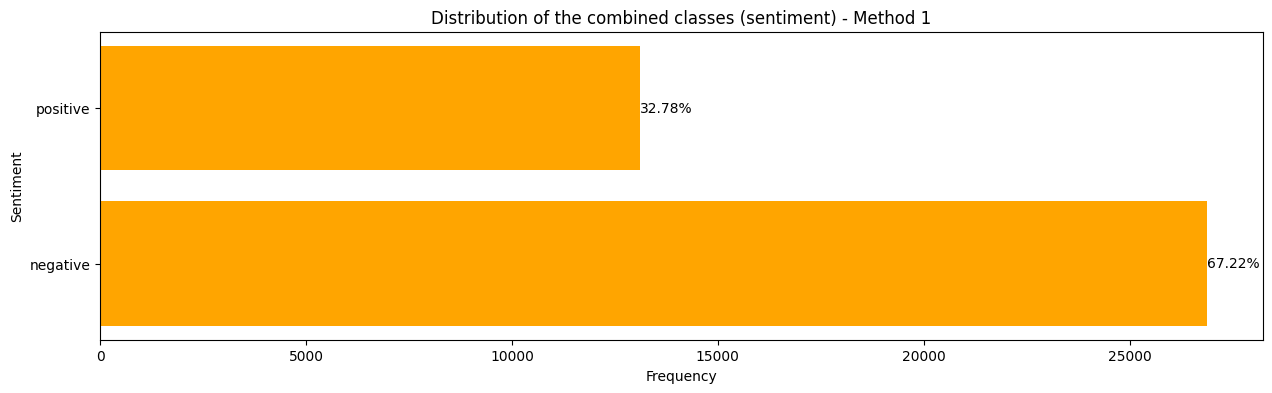

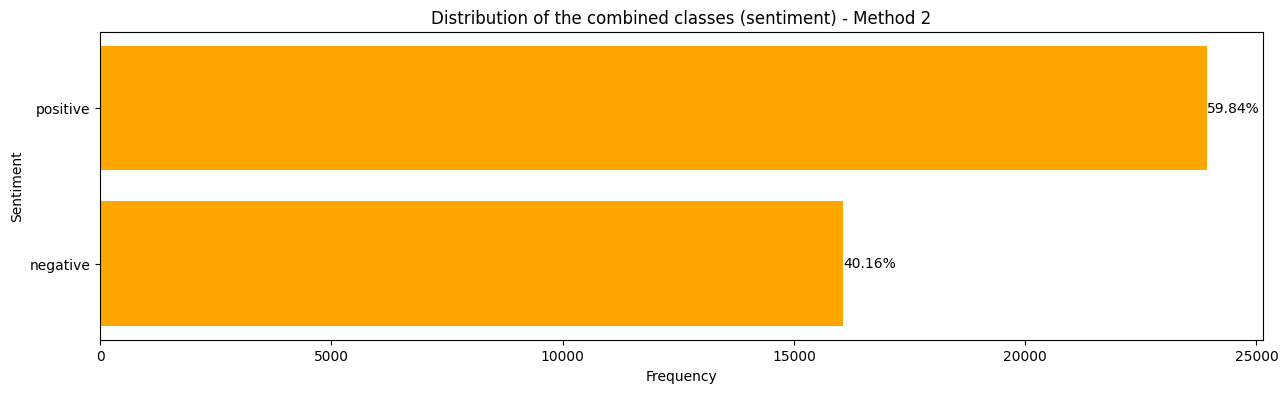

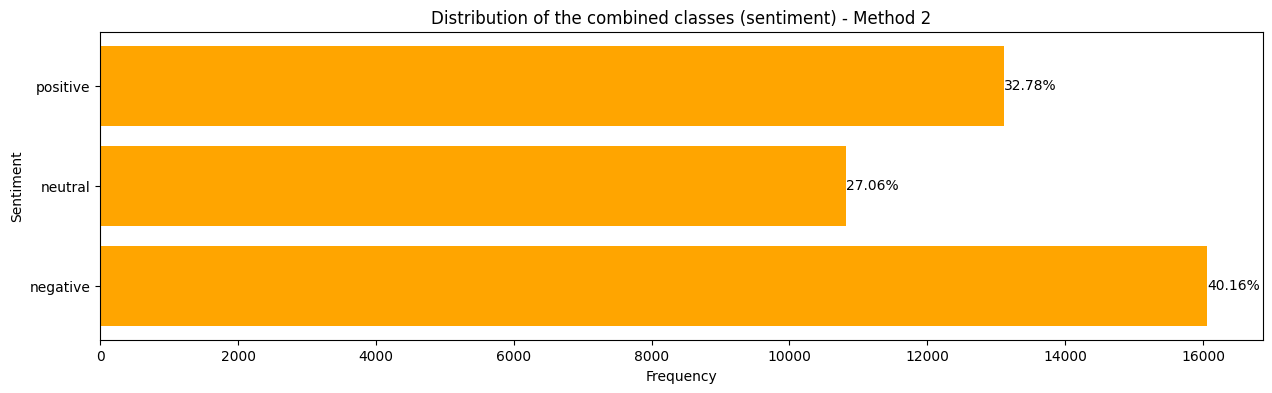

In [7]:
data = {"Class": sentiments, "Frequency": frequencies}

sentdf = pd.DataFrame(data)

group_mapping = {
    'enthusiasm': 'positive',
    'love': 'positive',
    'fun': 'positive',
    'happiness': 'positive',
    'relief': 'positive',
    'empty': 'negative',
    'sadness': 'negative',
    'worry': 'negative',
    'hate': 'negative',
    'boredom': 'negative',
    'anger': 'negative',
    'surprise': 'neutral',
    'neutral': 'neutral'
}

sentdf["Map"] = sentdf["Class"].map(group_mapping)

grouped_df = sentdf.groupby("Map")["Frequency"].sum().reset_index()

grouped_df_method1 = grouped_df.copy()
grouped_df_method1.loc[grouped_df_method1["Map"].isin(['neutral', 'surprise']), "Map"] = 'negative'
grouped_method1 = grouped_df_method1.groupby("Map")["Frequency"].sum()


plt.figure(figsize=(15, 4))
plt.barh(grouped_method1.index, grouped_method1.values, color='orange')
for i, v in enumerate(grouped_method1.values):
    plt.text(v, i, f"{(v / grouped_method1.sum()) * 100:.2f}%", color='black', va='center')
plt.title("Distribution of the combined classes (sentiment) - Method 1")
plt.xlabel("Frequency")
plt.ylabel("Sentiment")
plt.show()

grouped_df_method2 = grouped_df.copy()
grouped_df_method2.loc[grouped_df_method2["Map"].isin(['neutral', 'surprise']), "Map"] = 'positive'
grouped_method2 = grouped_df_method2.groupby("Map")["Frequency"].sum()

plt.figure(figsize=(15, 4))
plt.barh(grouped_method2.index, grouped_method2.values, color='orange')
for i, v in enumerate(grouped_method2.values):
    plt.text(v, i, f"{(v / grouped_method2.sum()) * 100:.2f}%", color='black', va='center')
plt.title("Distribution of the combined classes (sentiment) - Method 2")
plt.xlabel("Frequency")
plt.ylabel("Sentiment")
plt.show()

grouped_df = grouped_df.groupby("Map")["Frequency"].sum()

plt.figure(figsize=(15, 4))
plt.barh(grouped_df.index, grouped_df.values, color='orange')
for i, v in enumerate(grouped_df.values):
    plt.text(v, i, f"{(v / grouped_df.sum()) * 100:.2f}%", color='black', va='center')
plt.title("Distribution of the combined classes (sentiment) - Method 2")
plt.xlabel("Frequency")
plt.ylabel("Sentiment")
plt.show()

<p>Now based on the above analysis we can make following points :-</p>
<ol>
<li>Based on the <strong>frequency count</strong> and <strong>bar plot</strong> of the frequencies of the target feature, it can be observed that there is a major imbalance in the dataset.</li>
<li>Out of 13 target feature classes, 9 of them have less than 10% of data samples. This means that some of our models could suffer from "class imbalance", which could ultimately affect our results. <strong>[Refer Bibliography]</strong></li>
<li>Upon three different <strong>grouped analysis</strong> of the target feature classes, we can observe that the best combination is to group the classes into three broad categories as <strong>"Positive", "Negative" and "Neutral",</strong> this gives us a dataset which is ultimately balanced. We will have to transform our feature data into this new mapping for our training models.</li>
</ol>
<p><strong>Bibliography:</strong> <a href="https://machinelearningmastery.com/what-is-imbalanced-classification/">Imbalanced dataset</a></p>

<h4>Textual Data Analysis</h4>

In [10]:
print(df[predictor])
print("\n")

                                                 content
0      @tiffanylue i know  i was listenin to bad habi...
1      Layin n bed with a headache  ughhhh...waitin o...
2                    Funeral ceremony...gloomy friday...
3                   wants to hang out with friends SOON!
4      @dannycastillo We want to trade with someone w...
...                                                  ...
39995                                   @JohnLloydTaylor
39996                     Happy Mothers Day  All my love
39997  Happy Mother's Day to all the mommies out ther...
39998  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
39999  @mopedronin bullet train from tokyo    the gf ...

[40000 rows x 1 columns]




In [12]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amvik13/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/amvik13/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
pattern = r'@[A-Za-z0-9_]+'

display(df[df[predictor[0]].str.contains(pattern, regex=True, na=False)])

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?
...,...,...,...
39992,1753918881,neutral,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
39995,1753918954,neutral,@JohnLloydTaylor
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [14]:
pattern = r'http\S+'

display(df[df[predictor[0]].str.contains(pattern, regex=True, na=False)])

,tweet_id,sentiment,content
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
22,1956972116,neutral,No Topic Maps talks at the Balisage Markup Con...
33,1956975876,neutral,feels strong contractions but wants to go out....
73,1956984559,neutral,says I miss plurking. http://plurk.com/p/wxion
97,1956989560,sadness,feels sad coz i wasnt able to play with the gu...
...,...,...,...
39883,1753887627,neutral,Obama last night: &quot;Most of you covered me...
39908,1753902750,happiness,@rasga Yep: http://bit.ly/15yyId We go there ...
39921,1753903086,love,@wossy http://twitpic.com/24mer - i like Mr Pi...
39926,1753903172,happiness,http://bit.ly/X7D1c Spanish Grand Prix 2009 ...


In [15]:
pattern = r'([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)'

display(df[df[predictor[0]].str.contains(pattern, regex=True, na=False)])

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
...,...,...,...
39992,1753918881,neutral,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
39995,1753918954,neutral,@JohnLloydTaylor
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [8]:
def clean_and_preprocess(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9]', ' ', text)
    words = text.lower().split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

print("Example of stopword that are NOT being lemmetized and essentially removed:-")
print(stopwords.words("english")[-10:])
print("\n")
print("Comparing the clean and processed text with original text")
print("\n")
print("transformed: ",df[predictor[0]].apply(clean_and_preprocess)[0])
print("\n")
print("original: ",df[predictor[0]][0])

Example of stopword that are NOT being lemmetized and essentially removed:-
['shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


Comparing the clean and processed text with original text


transformed:  know listenin bad habit earlier started freakin part


original:  @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[


In [17]:
X = df[predictor[0]].apply(clean_and_preprocess)

count_vectorizer = CountVectorizer()
freq_term_matrix = count_vectorizer.fit_transform(X)

tfidf = TfidfTransformer(norm = "l2")
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

dense_tf_idf_matrix = tf_idf_matrix.toarray() 

print("The final transformed tf-idf matrix is as follows:-") 
print("\n")
print("Shape of tf-idf matrix: ", dense_tf_idf_matrix.shape)
print("\n")
print(dense_tf_idf_matrix)

The final transformed tf-idf matrix is as follows:-


Shape of tf-idf matrix:  (40000, 27579)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<p>Now based on the above analysis we can make following points :-</p>
<ol>
<li>There is a small number of samples for&nbsp;which the feature column "context" is <strong>duplicated.</strong> This small number of duplicates <strong>can be removed</strong> without any major impact on dataset.</li>
<li>Upong trying and examining various kind <strong>regex patterns</strong>, it is observed that most of the value for feature variable "content" can be <strong>cleaned and filtered</strong> to remove all the <strong>un-necessary stop words</strong> and <strong>tokens</strong> using <strong>3 kind</strong> of regex patterns. We will use the <strong>"clean_and_preprocess"&nbsp;</strong>method as a <strong>custom transformer&nbsp;</strong>for our training pipeline.</li>
<li>We will use <strong>TF-IDF</strong>&nbsp;algorithm<strong>&nbsp;</strong>transformer during our <strong>feature engineering</strong> step for <strong>vectorizing</strong> our&nbsp;<strong>cleaned and lemmetized&nbsp;</strong>texual data into <strong>numerical vector.</strong></li>
</ol>
<p><strong>Bibliography:&nbsp;</strong>1) <a href="https://towardsdatascience.com/how-tf-idf-works-3dbf35e568f0">How tf-idf works</a>&nbsp;2) <a href="https://constellate.org/docs/what-is-tf-idf">TF-IDF calculation</a>&nbsp;3) <a href="https://www.datacamp.com/tutorial/stemming-lemmatization-python">Lemmatization using nltk</a>&nbsp;4) <a href="https://regexone.com/">regexone</a></p>
<p>&nbsp;</p>

# Data Preprocessing

In [9]:
print(predictor)
print("\n")

print("Group mapping for transformed target feature:-")
print(group_mapping)
print("\n")

print("Features to drop are:-")
print(features_drop)
print("\n")

print("Target Feature:",target_class)

Index(['content'], dtype='object')


Group mapping for transformed target feature:-
{'enthusiasm': 'positive', 'love': 'positive', 'fun': 'positive', 'happiness': 'positive', 'relief': 'positive', 'empty': 'negative', 'sadness': 'negative', 'worry': 'negative', 'hate': 'negative', 'boredom': 'negative', 'anger': 'negative', 'surprise': 'neutral', 'neutral': 'neutral'}


Features to drop are:-
Index(['tweet_id'], dtype='object')


Target Feature: sentiment


In [11]:
class FeatureDrop(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X = X.drop(self.features,axis=1)
        return X

class CleanAndLemmetize(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X[predictor[0]] = X[predictor[0]].apply(clean_and_preprocess)
        return X

class TextVectorization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.count_vectorizer = CountVectorizer()
        self.tfidf = TfidfTransformer(norm = "l2")
        
    def fit(self, X, y=None):
        freq_term_matrix = self.count_vectorizer.fit_transform(X[predictor[0]])
        self.tfidf.fit(freq_term_matrix)
        return self
        
    def transform(self, X, y=None):
        freq_term_matrix = self.count_vectorizer.transform(X[predictor[0]])
        tf_idf_matrix = self.tfidf.transform(freq_term_matrix)
        X = tf_idf_matrix.toarray() 
        return X

drop_feat = FeatureDrop(features_drop.join([target_class], how="outer"))
label_enc = LabelEncoder()
lemmetize = CleanAndLemmetize()
text2vec = TextVectorization()

<h4> Train Test Split </h4>

In [12]:
df_train, df_test = train_test_split(df,stratify=df[target_class],test_size=0.2, random_state=42)

print("Length of df_train is : {}".format(len(df_train)))
print(df_train[target_class].value_counts())
print("\n")

print("Length of df_test is : {}".format(len(df_test)))
print(df_test[target_class].value_counts())
print("\n")

Length of df_train is : 32000
sentiment
neutral       6910
worry         6767
happiness     4167
sadness       4132
love          3074
surprise      1750
fun           1421
relief        1221
hate          1058
empty          662
enthusiasm     607
boredom        143
anger           88
Name: count, dtype: int64


Length of df_test is : 8000
sentiment
neutral       1728
worry         1692
happiness     1042
sadness       1033
love           768
surprise       437
fun            355
relief         305
hate           265
empty          165
enthusiasm     152
boredom         36
anger           22
Name: count, dtype: int64




# Model Training and Evaluation

<p>Based on above all the analysis, we will use 2 kind of models to train and evaluate our data. These models are :-</p>
<ol>
<li>) <strong>Multinomial Naive Bayes</strong></li>
<li>) <strong>SVM</strong></li>
</ol>
<p>Multinomial NB is an ideal choice for this kind of dataset as it is an extension of Gaussian NB which is designed for the <strong>dense discrete features </strong>like&nbsp;word counts for text classification. <strong>[Refer Bibliography]</strong></p>
<p>Now the model training plan would be similar for both models and is outlined below :-</p>
<ul>
<li><strong>model&nbsp;= {"Feature Drop", "Feature Map", "Feature Cleaning and Lemmetization", "Text Feature vectorization", "Parameter Tuning", "Training", "Evaluation" }</strong></li>
</ul>
<p><strong>Bibliography:&nbsp;</strong><a href="https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html">Multinomial NB</a></p>

In [13]:
def evaluation(y_pred,y_test):
    print("Accuracy = ", accuracy_score(y_test, y_pred))
    print("\n")

    print("The confusion matrix is as follows:-")
    print(confusion_matrix(y_test,y_pred))
    print("\n")

    print("The classification report is as follows:-")
    print(classification_report(y_test,y_pred))
    print("\n")

<h4>Multinomial Naive Bayes</h4>

Pipeline(steps=[('featuredrop',
                 FeatureDrop(features=Index(['sentiment', 'tweet_id'], dtype='object'))),
                ('cleanandlemmetize', CleanAndLemmetize()),
                ('textvectorization', TextVectorization()),
                ('multinomialnb', MultinomialNB())])

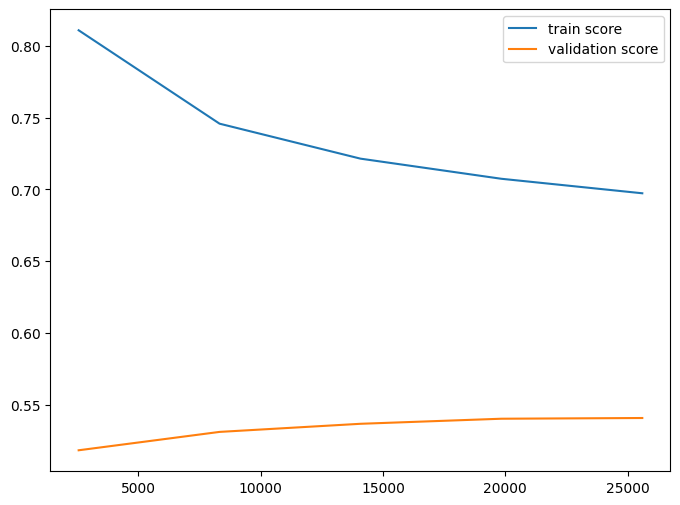

In [170]:
X_train, y_train = df_train.copy(), df_train[target_class].copy()
y_train = y_train.map(group_mapping)

X_test, y_test = df_test.copy(), df_test[target_class].copy()
y_test = y_test.map(group_mapping)

mgnb = MultinomialNB()

mgnb_pipeline = make_pipeline(drop_feat, lemmetize, text2vec, mgnb)

stratcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

N, train_score, val_score = learning_curve(mgnb_pipeline, X_train, y_train, cv=stratcv, scoring='accuracy', train_sizes=np.linspace(0.1,1,5))

plt.figure(figsize=(8,6))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

mgnb_pipeline.fit(X_train, y_train)

In [171]:
y_pred = mgnb_pipeline.predict(X_test)

print(evaluation(y_pred,y_test))

Accuracy =  0.54925


The confusion matrix is as follows:-
[[2745   78  390]
 [1412  152  601]
 [1046   79 1497]]


The classification report is as follows:-
              precision    recall  f1-score   support

    negative       0.53      0.85      0.65      3213
     neutral       0.49      0.07      0.12      2165
    positive       0.60      0.57      0.59      2622

    accuracy                           0.55      8000
   macro avg       0.54      0.50      0.45      8000
weighted avg       0.54      0.55      0.49      8000



None


<h4> SVM </h4>

In [ ]:
X_train, y_train = df_train.copy(), df_train[target_class].copy()
y_train = y_train.map(group_mapping)
y_train = label_enc.fit_transform(y_train)

X_test, y_test = df_test.copy(), df_test[target_class].copy()
y_test = y_test.map(group_mapping)
y_test = label_enc.fit_transform(y_test)

svm = SVC(probability=False,gamma="auto")

svm_pipeline = make_pipeline(drop_feat, lemmetize, text2vec, svm)

svm_pipeline.fit(X_train, y_train)

In [ ]:
y_pred = mgnb_pipeline.predict(X_test)

print(evaluation(y_pred,y_test))

<h4>KNN</h4>

In [ ]:
knn_train, knn_val = train_test_split(df_train,test_size=0.2, random_state=42)

X_train, y_train = knn_train.copy(), knn_train[target_class].copy()
y_train = y_train.map(group_mapping)
y_train = label_enc.fit_transform(y_train)

X_val, y_val = knn_val.copy(), knn_val[target_class].copy()
y_val = y_val.map(group_mapping)
y_val = label_enc.fit_transform(y_val)

knn_pipeline = make_pipeline(drop_feat,lemmetize,text2vec)

X_train = knn_pipeline.fit_transform(X_train)
X_val = knn_pipeline.transform(X_val)

k_values = range(1, 10)
training_errors = []
testing_errors = []

for k in k_values:
    print("Processing k={}".format(k))
    knn = KNeighborsClassifier(n_neighbors=k,metric="chebyshev")
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_val = knn.predict(X_val)
    training_errors.append(1 - accuracy_score(y_train, y_pred_train))
    testing_errors.append(1 - accuracy_score(y_val, y_pred_val))
    print("Done with k={} value".format(k))

plt.figure(figsize=(10, 6))
plt.plot(k_values, training_errors, marker='o', linestyle='--', color='red', label='Training Error')
plt.plot(k_values, testing_errors, marker='o', linestyle='--', color='blue', label='Validation Error')
plt.xticks(k_values)
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.legend()
plt.grid()
plt.show()

Processing k=1
